# Running Oktoberfest

## 1- Import necessary python packages

In [1]:
import os
from oktoberfest.runner import run_job
import json
import urllib.request
import shutil
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

2023-05-31 16:31:19.482891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 16:31:20.069462: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-31 16:31:20.069499: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-31 16:31:21.311714: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## 2- Download files from zenodo required to run different tasks

### A- Get the current directory and set the file name

In [2]:
download_dir = os.getcwd()
download_file = os.path.join(download_dir, 'Oktoberfest_input.zip')
url = 'https://zenodo.org/record/7613029/files/Oktoberfest_input.zip'

download = False  # set this to false if you already have the file and don't want to download again in the next step

### B- Download files from zenodo to the same directory

In [3]:
if download:
    with tqdm(unit="B", total=2739196307, unit_scale=True, unit_divisor=1024, miniters=1, desc=url.split("/")[-1]) as t:
        urllib.request.urlretrieve(url=url, filename=download_file, reporthook=lambda blocks, block_size, _: t.update(blocks * block_size - t.n))        

### C- Extract the downloaded file in the same directory

In [4]:
#shutil.unpack_archive(download_file, download_dir)
input_dir = download_file[:-4]
print(f'Downloaded data is stored in {input_dir}\nContents:')
os.listdir(input_dir)

Downloaded data is stored in /home/mario/phd/wilhelmlab/oktoberfest/tutorials/Oktoberfest_input
Contents:


['proc',
 'GN20170722_SK_HLA_G0103_R1_02.raw',
 'GN20170722_SK_HLA_G0103_R2_02.raw',
 'msms.prosit',
 'ce_calibration_config.json',
 'GN20170722_SK_HLA_G0103_R2_01.raw',
 'config_files',
 'results',
 'peptides_spectral_library.csv',
 'mzML',
 'msms.txt',
 'msms',
 'spectral_library_config.json',
 'rescoring_config.json']

## 3- Running Different Tasks

### A- Spectral Library Generation

#### Generate config file

In [21]:
task_config_spectral_lib = {
    "type":"SpectralLibraryGeneration",
    "tag":"",
    "fileUploads":{
        "search_type":'',
        "raw_type":'',
        "fasta":False,
        "peptides.csv":True
    },
    "models":{
        "intensity":'Prosit_2020_intensity_hcd',
        "irt":'Prosit_2019_irt'
    },
    "outputFormat":"spectronaut",
    "prosit_server":"proteomicsdb.org:8500"
}

#### Save config as json

In [22]:
with open(input_dir + '/spectral_library_config.json', 'w') as fp:
    json.dump(task_config_spectral_lib, fp)

#### Run spectral library generation job

In [23]:
config_path = os.path.join(input_dir, "spectral_library_config.json")
run_job(input_dir, config_path)

2023-05-31 16:59:54,733 - INFO - oktoberfest.utils.config::read Reading configuration from /home/mario/phd/wilhelmlab/oktoberfest/tutorials/Oktoberfest_input/spectral_library_config.json
2023-05-31 16:59:54,736 - INFO - oktoberfest.utils.config::read Reading configuration from /home/mario/phd/wilhelmlab/oktoberfest/tutorials/Oktoberfest_input/spectral_library_config.json
2023-05-31 16:59:54,752 - INFO - oktoberfest.runner::generate_spectral_lib No of sequences before Filtering is 5
2023-05-31 16:59:54,763 - INFO - oktoberfest.runner::generate_spectral_lib No of sequences after Filtering is 5
2023-05-31 16:59:54,770 - INFO - oktoberfest.runner::generate_spectral_lib Last Batch from index 0
2023-05-31 16:59:54,771 - INFO - oktoberfest.runner::generate_spectral_lib Batch of size 5
2023-05-31 16:59:54,772 - INFO - oktoberfest.spectral_library::grpc_predict /home/mario/phd/wilhelmlab/oktoberfest/oktoberfest/certificates


/home/mario/phd/wilhelmlab/oktoberfest/oktoberfest/spectral_library.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  library.spectra_data.loc[:, "GRPC_SEQUENCE"] = library.spectra_data["MODIFIED_SEQUENCE"]


### B- CE Calibration

#### Generate config file

In [28]:
task_config_ce_calibration = {
    "type":"CollisionEnergyCalibration",
    "tag":"",
    "fileUploads":{
        "search_type":'Maxquant',
        "raw_type":'thermo',
        "fasta":False,
        "peptides.csv":False
    },
    "models":{
        "intensity":'Prosit_2020_intensity_hcd',
        "irt":'Prosit_2019_irt'
    },
    "outputFormat":"",
    "prosit_server":"proteomicsdb.org:8500"
}

#### Save config as json

In [29]:
with open(input_dir + '/ce_calibration_config.json', 'w') as fp:
    json.dump(task_config_ce_calibration, fp)

#### Run ce calibration job

In [30]:
download_dir

'/home/mario/phd/wilhelmlab/oktoberfest/tutorials'

2023-05-31 17:02:47,003 - INFO - oktoberfest.utils.config::read Reading configuration from /home/mario/phd/wilhelmlab/oktoberfest/tutorials/Oktoberfest_input/ce_calibration_config.json
2023-05-31 17:02:47,005 - INFO - oktoberfest.utils.config::read Reading configuration from /home/mario/phd/wilhelmlab/oktoberfest/tutorials/Oktoberfest_input/ce_calibration_config.json
2023-05-31 17:02:47,007 - INFO - oktoberfest.ce_calibration::_load_search search_type is maxquant
2023-05-31 17:02:47,008 - INFO - oktoberfest.ce_calibration::_gen_internal_search_result_from_msms Converting msms data at /home/mario/phd/wilhelmlab/oktoberfest/tutorials/Oktoberfest_input/msms.txt to internal search result.
2023-05-31 17:02:47,008 - INFO - spectrum_io.search_result.search_results::generate_internal Found search results in internal format at /home/mario/phd/wilhelmlab/oktoberfest/tutorials/Oktoberfest_input/msms.prosit, skipping conversion
2023-05-31 17:02:47,239 - INFO - oktoberfest.ce_calibration::perform_a

/home/mario/phd/wilhelmlab/oktoberfest/oktoberfest/ce_calibration.py:194: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  hcd_df = self.library.spectra_data[(self.library.spectra_data["FRAGMENTATION"] == "HCD")]


ValueError: cannot reindex on an axis with duplicate labels

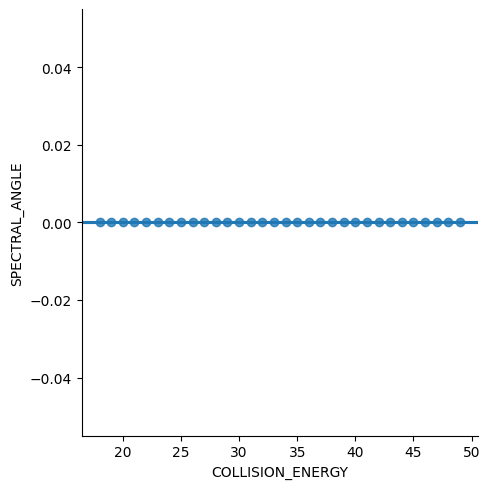

In [32]:
config_path = os.path.join(input_dir, "ce_calibration_config.json")
run_job(input_dir, config_path)

### C- Rescoring

#### Generate config file

In [33]:
task_config_rescoring = {
    "type":"Rescoring",
    "tag":"",
    "fileUploads":{
        "search_type":'Maxquant',
        "raw_type":'thermo',
        "fasta":False,
        "peptides.csv":False
    },
    "models":{
        "intensity":'Prosit_2020_intensity_hcd',
        "irt":'Prosit_2019_irt'
    },
    "outputFormat":"",
    "prosit_server":"proteomicsdb.org:8500",
    "numThreads": 1
}

#### Save config as json

In [34]:
with open(input_dir + '/rescoring_config.json', 'w') as fp:
    json.dump(task_config_rescoring, fp)

#### Run rescoring job

2023-05-31 17:04:48,496 - INFO - oktoberfest.utils.config::read Reading configuration from /home/mario/phd/wilhelmlab/oktoberfest/tutorials/Oktoberfest_input/rescoring_config.json
2023-05-31 17:04:48,498 - INFO - oktoberfest.utils.config::read Reading configuration from /home/mario/phd/wilhelmlab/oktoberfest/tutorials/Oktoberfest_input/rescoring_config.json
2023-05-31 17:04:48,500 - INFO - oktoberfest.re_score::get_raw_files Found 3 raw files in the search directory
/home/mario/phd/wilhelmlab/oktoberfest/tutorials/Oktoberfest_input/proc/split_msms.done -----------------
2023-05-31 17:04:48,502 - INFO - oktoberfest.utils.process_step::is_done Skipping split_msms step because /home/mario/phd/wilhelmlab/oktoberfest/tutorials/Oktoberfest_input/proc/split_msms.done was found.
/home/mario/phd/wilhelmlab/oktoberfest/tutorials/Oktoberfest_input/proc/calculate_features.GN20170722_SK_HLA_G0103_R1_02.done -----------------
/home/mario/phd/wilhelmlab/oktoberfest/tutorials/Oktoberfest_input/GN20170

/home/mario/miniconda3/envs/oktoberfest/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


2023-05-31 17:05:12,553 - INFO - spectrum_io.file.hdf5::write_dataset Data appended to /home/mario/phd/wilhelmlab/oktoberfest/tutorials/Oktoberfest_input/mzML/GN20170722_SK_HLA_G0103_R1_02.mzML.pred.hdf5
2023-05-31 15:05:14,261 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.01 out of 15697 targets in total


2023-05-31 15:05:14,261 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.01 out of 15697 targets in total


2023-05-31 15:05:14,263 - INFO - spectrum_fundamentals.metrics.percolator::apply_lda_and_get_indices_below_fdr Found 0 targets and 10773 decoys as input for the LDA model
2023-05-31 15:05:14,505 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.01 out of 15697 targets in total


2023-05-31 15:05:14,505 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.01 out of 15697 targets in total


2023-05-31 15:05:14,542 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.02 out of 15697 targets in total


2023-05-31 15:05:14,542 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.02 out of 15697 targets in total


2023-05-31 15:05:14,545 - INFO - spectrum_fundamentals.metrics.percolator::apply_lda_and_get_indices_below_fdr Found 0 targets and 10773 decoys as input for the LDA model
2023-05-31 15:05:14,947 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.02 out of 15697 targets in total


2023-05-31 15:05:14,947 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.02 out of 15697 targets in total


2023-05-31 15:05:14,981 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.03 out of 15697 targets in total


2023-05-31 15:05:14,981 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.03 out of 15697 targets in total


2023-05-31 15:05:14,985 - INFO - spectrum_fundamentals.metrics.percolator::apply_lda_and_get_indices_below_fdr Found 0 targets and 10773 decoys as input for the LDA model
2023-05-31 15:05:15,277 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.03 out of 15697 targets in total


2023-05-31 15:05:15,277 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.03 out of 15697 targets in total


2023-05-31 15:05:15,353 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.04 out of 15697 targets in total


2023-05-31 15:05:15,353 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.04 out of 15697 targets in total


2023-05-31 15:05:15,356 - INFO - spectrum_fundamentals.metrics.percolator::apply_lda_and_get_indices_below_fdr Found 0 targets and 10773 decoys as input for the LDA model
2023-05-31 15:05:15,727 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.04 out of 15697 targets in total


2023-05-31 15:05:15,727 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.04 out of 15697 targets in total


2023-05-31 15:05:15,757 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.05 out of 15697 targets in total


2023-05-31 15:05:15,757 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.05 out of 15697 targets in total


2023-05-31 15:05:15,760 - INFO - spectrum_fundamentals.metrics.percolator::apply_lda_and_get_indices_below_fdr Found 0 targets and 10773 decoys as input for the LDA model
2023-05-31 15:05:16,056 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.05 out of 15697 targets in total


2023-05-31 15:05:16,056 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.05 out of 15697 targets in total


2023-05-31 15:05:16,094 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.060000000000000005 out of 15697 targets in total


2023-05-31 15:05:16,094 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.060000000000000005 out of 15697 targets in total


2023-05-31 15:05:16,098 - INFO - spectrum_fundamentals.metrics.percolator::apply_lda_and_get_indices_below_fdr Found 0 targets and 10773 decoys as input for the LDA model
2023-05-31 15:05:16,499 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.060000000000000005 out of 15697 targets in total


2023-05-31 15:05:16,499 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.060000000000000005 out of 15697 targets in total


2023-05-31 15:05:16,540 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.07 out of 15697 targets in total


2023-05-31 15:05:16,540 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.07 out of 15697 targets in total


2023-05-31 15:05:16,542 - INFO - spectrum_fundamentals.metrics.percolator::apply_lda_and_get_indices_below_fdr Found 0 targets and 10773 decoys as input for the LDA model
2023-05-31 15:05:16,962 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.07 out of 15697 targets in total


2023-05-31 15:05:16,962 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.07 out of 15697 targets in total


2023-05-31 15:05:17,006 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.08 out of 15697 targets in total


2023-05-31 15:05:17,006 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.08 out of 15697 targets in total


2023-05-31 15:05:17,008 - INFO - spectrum_fundamentals.metrics.percolator::apply_lda_and_get_indices_below_fdr Found 0 targets and 10773 decoys as input for the LDA model
2023-05-31 15:05:17,225 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.08 out of 15697 targets in total


2023-05-31 15:05:17,225 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.08 out of 15697 targets in total


2023-05-31 15:05:17,292 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.09 out of 15697 targets in total


2023-05-31 15:05:17,292 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.09 out of 15697 targets in total


2023-05-31 15:05:17,294 - INFO - spectrum_fundamentals.metrics.percolator::apply_lda_and_get_indices_below_fdr Found 0 targets and 10773 decoys as input for the LDA model
2023-05-31 15:05:17,554 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.09 out of 15697 targets in total


2023-05-31 15:05:17,554 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.09 out of 15697 targets in total


2023-05-31 15:05:17,613 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.09999999999999999 out of 15697 targets in total


2023-05-31 15:05:17,613 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.09999999999999999 out of 15697 targets in total


2023-05-31 15:05:17,617 - INFO - spectrum_fundamentals.metrics.percolator::apply_lda_and_get_indices_below_fdr Found 0 targets and 10773 decoys as input for the LDA model
2023-05-31 15:05:17,800 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.09999999999999999 out of 15697 targets in total


2023-05-31 15:05:17,800 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.09999999999999999 out of 15697 targets in total


2023-05-31 15:05:17,859 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.10999999999999999 out of 15697 targets in total


2023-05-31 15:05:17,859 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.10999999999999999 out of 15697 targets in total


2023-05-31 15:05:17,873 - INFO - spectrum_fundamentals.metrics.percolator::apply_lda_and_get_indices_below_fdr Found 0 targets and 10773 decoys as input for the LDA model
2023-05-31 15:05:18,085 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.10999999999999999 out of 15697 targets in total


2023-05-31 15:05:18,085 - ERROR - spectrum_fundamentals.metrics.percolator::get_indices_below_fdr Could not find any targets below 0.10999999999999999 out of 15697 targets in total
/home/mario/phd/wilhelmlab/spectrum_fundamentals/spectrum_fundamentals/metrics/percolator.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retention_time_df["rt_bin_index"] = np.digitize(retention_time_df["RETENTION_TIME"], break_points)


2023-05-31 15:06:12,063 - INFO - spectrum_fundamentals.metrics.percolator::calc Median absolute error predicted vs observed retention time on targets < 1% FDR: nan


/home/mario/miniconda3/envs/oktoberfest/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mario/miniconda3/envs/oktoberfest/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/home/mario/phd/wilhelmlab/oktoberfest/tutorials/Oktoberfest_input/proc/calculate_features.GN20170722_SK_HLA_G0103_R2_02.done -----------------
2023-05-31 17:06:24,451 - INFO - oktoberfest.utils.process_step::is_done Skipping calculate_features.GN20170722_SK_HLA_G0103_R2_02 step because /home/mario/phd/wilhelmlab/oktoberfest/tutorials/Oktoberfest_input/proc/calculate_features.GN20170722_SK_HLA_G0103_R2_02.done was found.
/home/mario/phd/wilhelmlab/oktoberfest/tutorials/Oktoberfest_input/proc/calculate_features.GN20170722_SK_HLA_G0103_R2_01.done -----------------
2023-05-31 17:06:24,451 - INFO - oktoberfest.utils.process_step::is_done Skipping calculate_features.GN20170722_SK_HLA_G0103_R2_01 step because /home/mario/phd/wilhelmlab/oktoberfest/tutorials/Oktoberfest_input/proc/calculate_features.GN20170722_SK_HLA_G0103_R2_01.done was found.
/home/mario/phd/wilhelmlab/oktoberfest/tutorials/Oktoberfest_input/proc/merge_input_prosit.done -----------------
2023-05-31 17:06:24,452 - INFO - okt

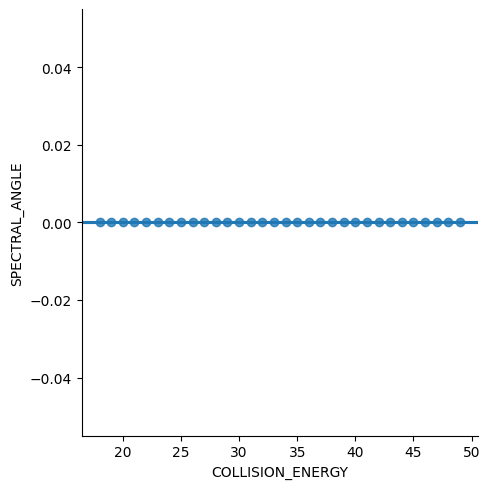

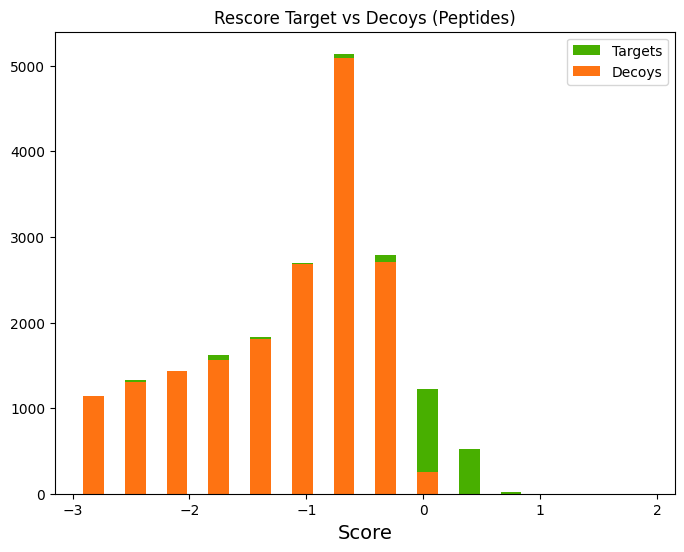

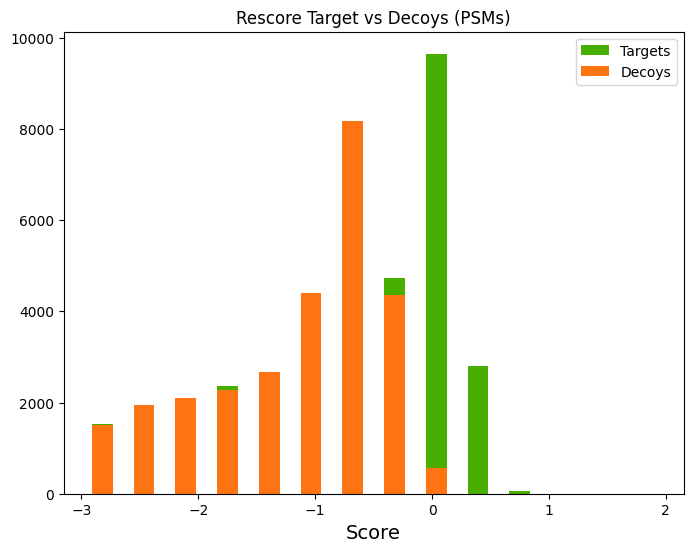

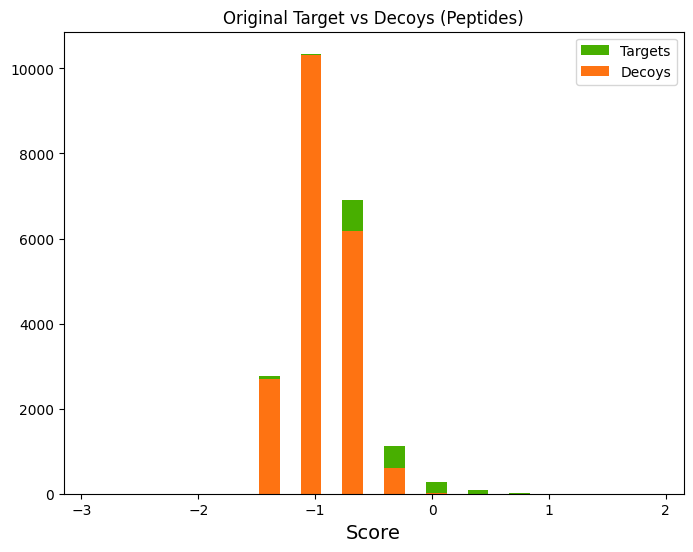

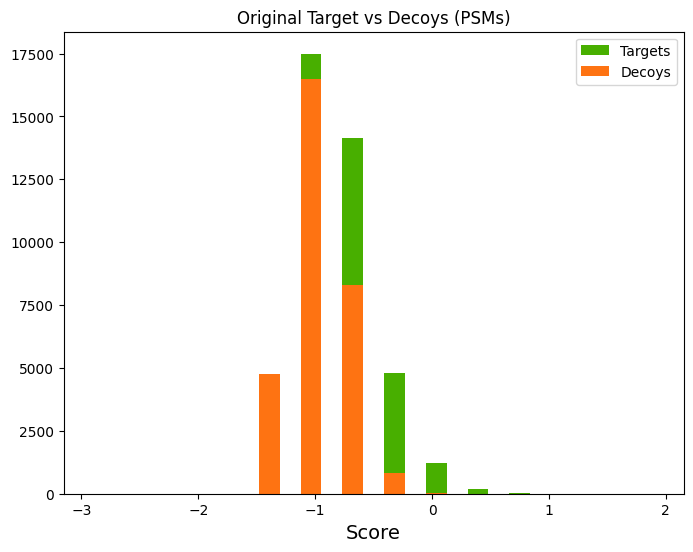

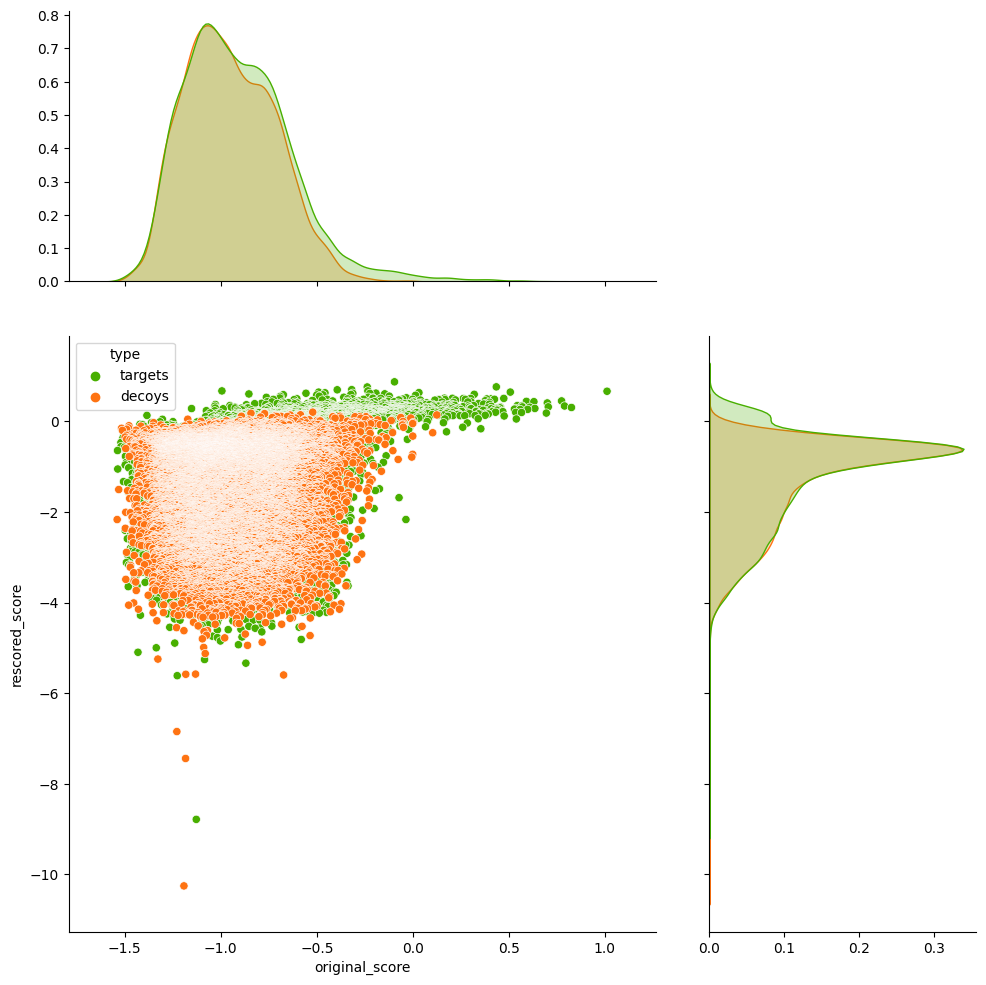

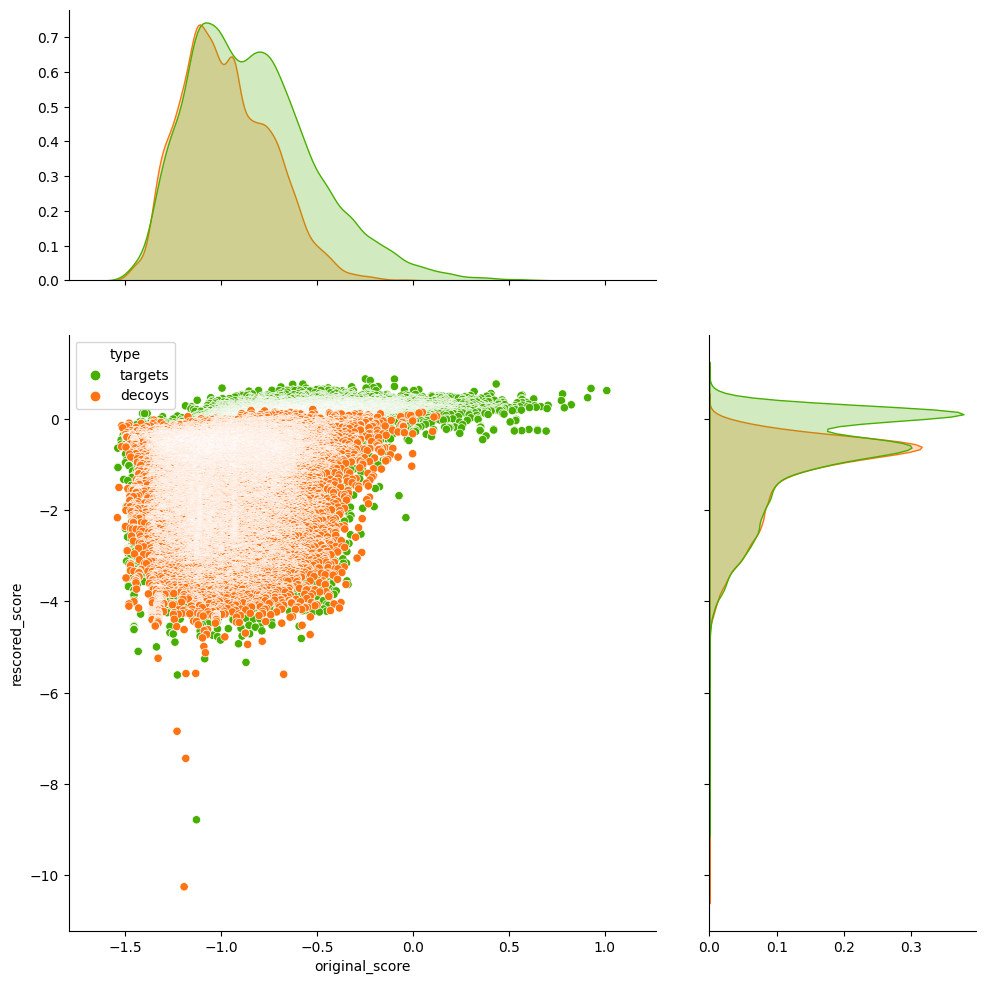

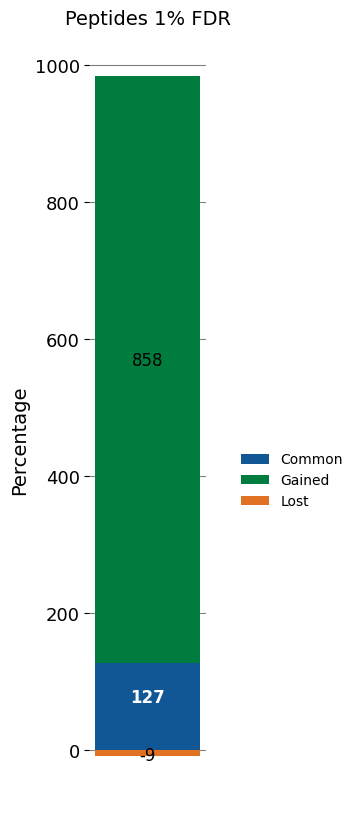

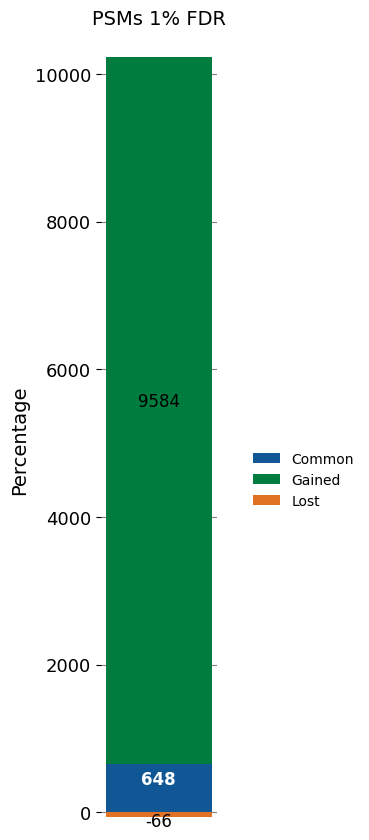

In [35]:
config_path = os.path.join(input_dir, "rescoring_config.json")
run_job(input_dir, config_path)